<a href="https://colab.research.google.com/github/haleywis/OPTI556/blob/main/556_FinalProj_Wiskoskiv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OPTI-556: Final Project 
# Coded Aperture Projection Tomography 

Haley Wiskoski 
University of Arizona



# Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from scipy import signal
from scipy import integrate
from scipy.ndimage.interpolation import rotate
from scipy.spatial.transform import Rotation as R
from skimage.transform import radon, rescale,  resize, warp
from scipy import interpolate
from skimage.transform import iradon_sart
%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 10]
plt.rcParams.update({'font.size': 22})
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
import cv2
from keras.datasets import mnist
from progressbar import ProgressBar

# Small-Scale Tests

## Loading and prepping data  
In this project, we will use the MNIST dataset of handwritten characters. In this section, we also create our forward model, H, with the embedded random coded aperture. To obtain projections along various angles of the object, we will utilize the single forward projection model and apply it iteratively to a rotated image for a defined number of projections. 

In [ ]:
# Loading test images (28x28 image size)
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.pad(x_train, ((0,0),(6,6),(6,6)), 'constant')
x_test =np.pad(x_test, ((0,0),(6,6),(6,6)), 'constant')
x_train=x_train.astype("float32")/255.0
x_test=x_test.astype("float32")/255.0


11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
# Creating the forward model, H
# NOTE: l is object distance from the coded aperture in waves, delta is the 
#       spacing between object elements, d is the distance from the detector,
#       N is the size of our square test image, M is the length of the coded
#       aperture & height of the forward model matrix

l= 10
delta=1
N=40
M=192
pbar1 = ProgressBar()

code=np.random.randint(0,2,M)
def t(x):
  t=code[np.int(np.floor((x+M/2)/delta))]
  return t
vt=np.vectorize(t)
def p(j):
  xj, yj=delta*divmod(j,N)
  xj=xj-N*delta/2
  yj=yj+l
  return xj, yj
def g(j,x):
  g=t((x+(l/p(j)[1])*p(j)[0])/(1+(l/p(j)[1])))
  return g
def h(i,j):
  h=integrate.quad(lambda x: g(j,x), (i-M/2)*delta-delta/2,(i-M/2)*delta +delta/2)[0]
  return h
H=np.zeros((M,N**2))

for j in pbar1(range(N**2)):
  for i in range(M):
    H[i,j]=h(i,j)

100% (1600 of 1600) |####################| Elapsed Time: 0:04:39 Time:  0:04:39


As can be seen below, the coded aperture spans a 192 x 1 array, where it shows a value of 1 for areas of transmission, and 0 for opaque areas blocking transmission. 

The discrete object in question is sized 28 x 28, but padded to 40x40, resulting in 1600 object elements for a delta = 1. Each column of H shown below depicts 1600 object element projections through the 192 element coded aperture (192 measurments), onto a single pixel of the detector. For 192 measurements of the object, we obtain a forward model sized 192 x 1600 (measurements by # of pixels). 

Text(0.5, 1.0, 'Initial Forward Model, H')

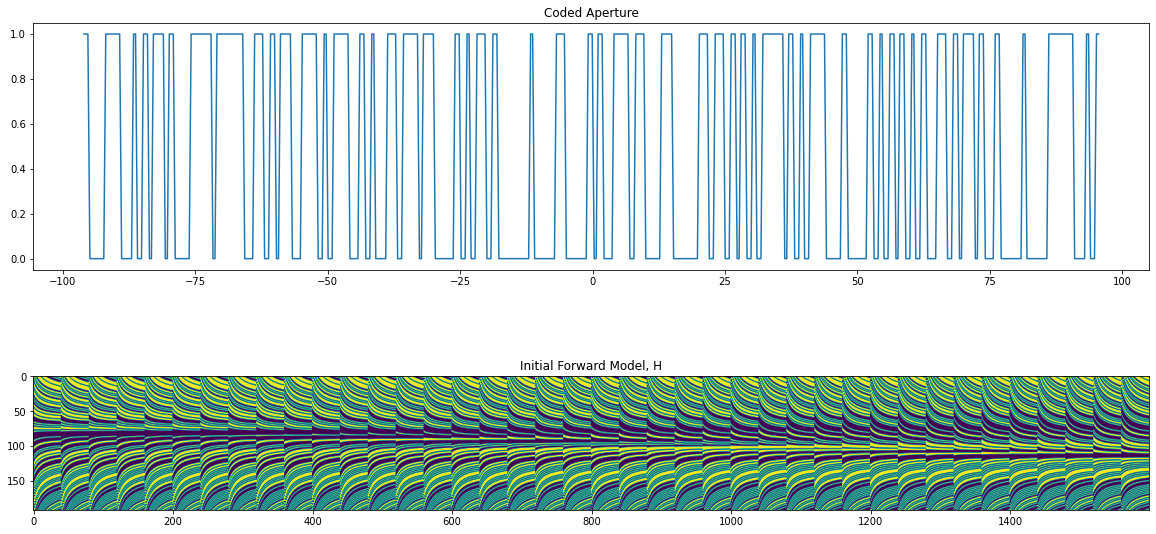

In [ ]:
# Displaying coded aperture and initial forward model 
xspace = np.linspace(-M*delta/2, (M-1)*delta/2, 512)
plt.rcParams['figure.figsize'] = [20,10]
plt.subplot(2,1,1)
plt.plot(xspace,vt(xspace))
plt.title('Coded Aperture')
plt.subplot(2,1,2)
plt.imshow(H)
plt.title('Initial Forward Model, H')


## Image Rotation, Single Forward Model

Here we test rotating images and applying the single forward model to the rotations.

Below we have the result of a rotated forward matrix. We reshape the initial forward model, maintaining how the data is read, to be compatible with a 2x2 rotational matrix. The two matrices are multiplied and the result is reshaped to its original dimensionality.

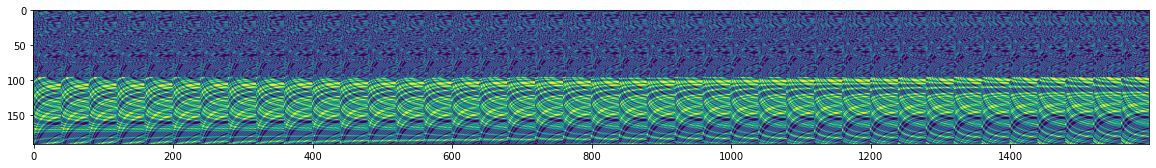

In [ ]:
theta = np.radians(45)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c, -s), (s, c)))

H45_test = np.reshape(H,(2,153600))
H45_test = np.dot(R,H45_test)
H45_test=np.reshape(H45_test,(192,1600))

plt.imshow(np.abs(H45_test))

Text(0.5, 1.0, 'H0 on Unrotated Obj')

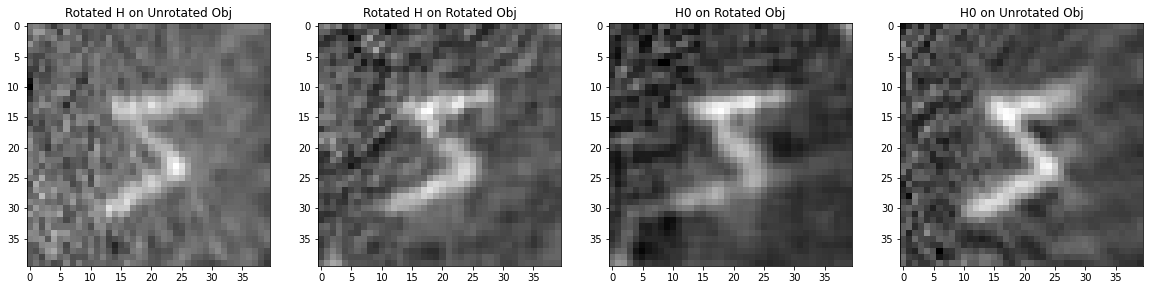

In [ ]:
# Some results
Imgrot_test1 = rotate(x_train[0,:,:], angle = 45, reshape = False)

H45_test = np.reshape(np.matmul(np.linalg.pinv(np.abs(H45_test)),np.matmul(np.abs(H45_test),np.reshape(x_train[0],N**2))),(N,N))

Htest45 = np.reshape(np.matmul(np.linalg.pinv(H45),np.matmul(H45,np.reshape(Imgrot_test1,N**2))),(N,N))
Htest45 = rotate(Htest45, angle = -45, reshape = False, mode='mirror')

H_rot1 = np.reshape(np.matmul(np.linalg.pinv(H),np.matmul(H,np.reshape(Imgrot_test1,N**2))),(N,N))
H_rot1 = rotate(H_rot1, angle = -45, reshape = False, mode = 'mirror')

H0 = np.reshape(np.matmul(np.linalg.pinv(H),np.matmul(H,np.reshape(x_train[0,:,:],N**2))),(N,N))

plt.subplot(1,4,1)
plt.imshow(H45_test,cmap='gray')
plt.title('Rotated H on Unrotated Obj')
plt.subplot(1,4,2)
plt.imshow(Htest45, cmap = 'gray')
plt.title('Rotated H on Rotated Obj')
plt.subplot(1,4,3)
plt.imshow(H_rot1, cmap = 'gray')
plt.title('H0 on Rotated Obj')
plt.subplot(1,4,4)
plt.imshow(H0, cmap = 'gray')
plt.title('H0 on Unrotated Obj')

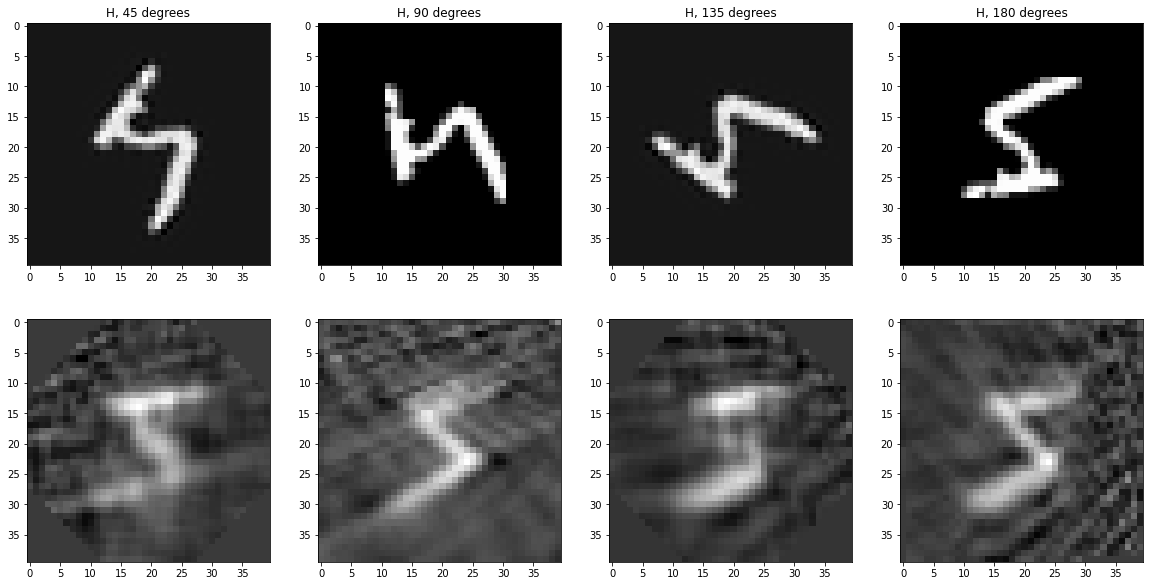

In [ ]:
# Image rotation and unrotated forward model application demonstration

Imgrot_test1 = rotate(x_train[0,:,:], angle = 45, reshape = False)
Imgrot_test2 = rotate(x_train[0,:,:], angle = 90, reshape = False)
Imgrot_test3 = rotate(x_train[0,:,:], angle = 135, reshape = False)
Imgrot_test4 = rotate(x_train[0,:,:], angle = 180, reshape = False)

H0 = np.reshape(np.matmul(np.linalg.pinv(H),np.matmul(H,np.reshape(x_train[0,:,:],N**2))),(N,N))
H_rot1 = np.reshape(np.matmul(np.linalg.pinv(H),np.matmul(H,np.reshape(Imgrot_test1,N**2))),(N,N))
H_rot2 = np.reshape(np.matmul(np.linalg.pinv(H),np.matmul(H,np.reshape(Imgrot_test2,N**2))),(N,N))
H_rot3 = np.reshape(np.matmul(np.linalg.pinv(H),np.matmul(H,np.reshape(Imgrot_test3,N**2))),(N,N))
H_rot4 = np.reshape(np.matmul(np.linalg.pinv(H),np.matmul(H,np.reshape(Imgrot_test4,N**2))),(N,N))

plt.subplot(2,4,1)
plt.imshow(Imgrot_test1, cmap = 'gray')
plt.title('H, 45 degrees')
plt.subplot(2,4,2)
plt.imshow(Imgrot_test2, cmap = 'gray')
plt.title('H, 90 degrees')
plt.subplot(2,4,3)
plt.imshow(Imgrot_test3, cmap = 'gray')
plt.title('H, 135 degrees')
plt.subplot(2,4, 4)
plt.imshow(Imgrot_test4, cmap = 'gray')
plt.title('H, 180 degrees')
plt.subplot(2,4,5)
H_rot1 = rotate(H_rot1, angle = -45, reshape = False)
plt.imshow(H_rot1, cmap = 'gray')
plt.subplot(2,4,6)
H_rot2 = rotate(H_rot2, angle = -90, reshape = False)
plt.imshow(H_rot2, cmap = 'gray')
plt.subplot(2,4,7)
H_rot3 = rotate(H_rot3, angle = -135, reshape = False)
plt.imshow(H_rot3, cmap = 'gray')
plt.subplot(2,4,8)
H_rot4 = rotate(H_rot4, angle = -180, reshape = False)
plt.imshow(H_rot4, cmap = 'gray')

We can see in the above projections that some of the rotations will cause clipping at the image edges. The above images show the results of zero-padding the object prior to rotation; if it is not padded the central object can be cut off by rotation. Below, we demonstrate the performance of four different boundary modes for the rotation function, and determine that the 'mirror' mode most accurately reflects the data at the corners of an unrotated or unclipped projection. 'Nearest' mode creates a smearing effect that does not depict the noise level that would occur in the projection, and 'wrap' mode essentially creates a blurred version of the image in the corners, also not depocting the noise level in the projection. 'Reflect' and 'mirror' most resemble what would exist in the corners of the projection had they not been clipped off due to rotation. As these corners of the projections don't contain important data of the central object, this is a reasonable approach to mitigating the effects. 

Text(0.5, 1.0, 'Wrap mode')

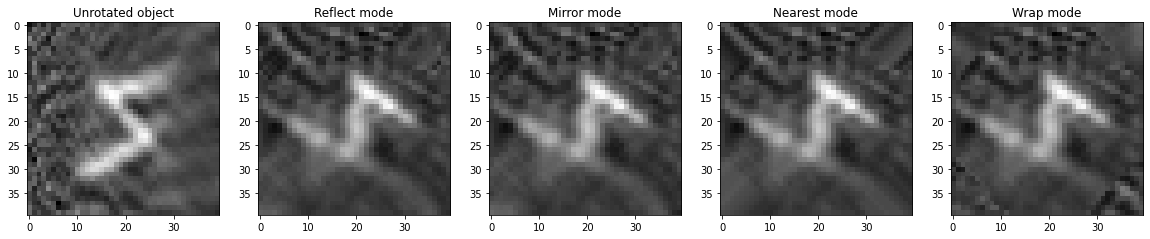

In [ ]:
plt.subplot(1,5,1)
plt.imshow(H0, cmap = 'gray')
plt.title('Unrotated object')
plt.subplot(1,5,2)
plt.imshow(rotate(H_rot1, angle = -45, reshape = False, mode = 'reflect'), cmap = 'gray')
plt.title('Reflect mode')
plt.subplot(1,5,3)
plt.imshow(rotate(H_rot1, angle = -45, reshape = False, mode = 'mirror'), cmap = 'gray')
plt.title('Mirror mode')
plt.subplot(1,5,4)
plt.imshow(rotate(H_rot1, angle = -45, reshape = False, mode = 'nearest'), cmap = 'gray')
plt.title('Nearest mode')
plt.subplot(1,5,5)
plt.imshow(rotate(H_rot1, angle = -45, reshape = False, mode = 'wrap'), cmap = 'gray')
plt.title('Wrap mode')

Text(0.5, 1.0, '180 deg')

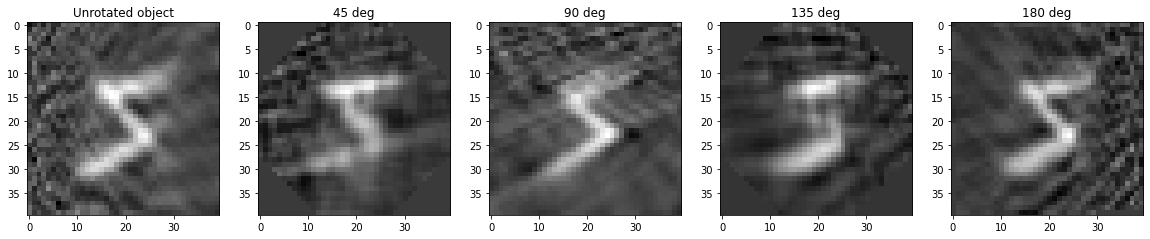

In [ ]:
# mirror mode on several rotations to check
plt.subplot(1,5,1)
plt.imshow(H0, cmap = 'gray')
plt.title('Unrotated object')
plt.subplot(1,5,2)
plt.imshow(H_rot1, cmap = 'gray')
plt.title('45 deg')
plt.subplot(1,5,3)
plt.imshow(H_rot2, cmap = 'gray')
plt.title('90 deg')
plt.subplot(1,5,4)
plt.imshow(H_rot3, cmap = 'gray')
plt.title('135 deg')
plt.subplot(1,5,5)
plt.imshow(H_rot4, cmap = 'gray')
plt.title('180 deg')

## Rotated Forward Models, Single Image Orientation

Below shows reconstruction from a +/- x-direction forward model, and +/- 45 degree forward model

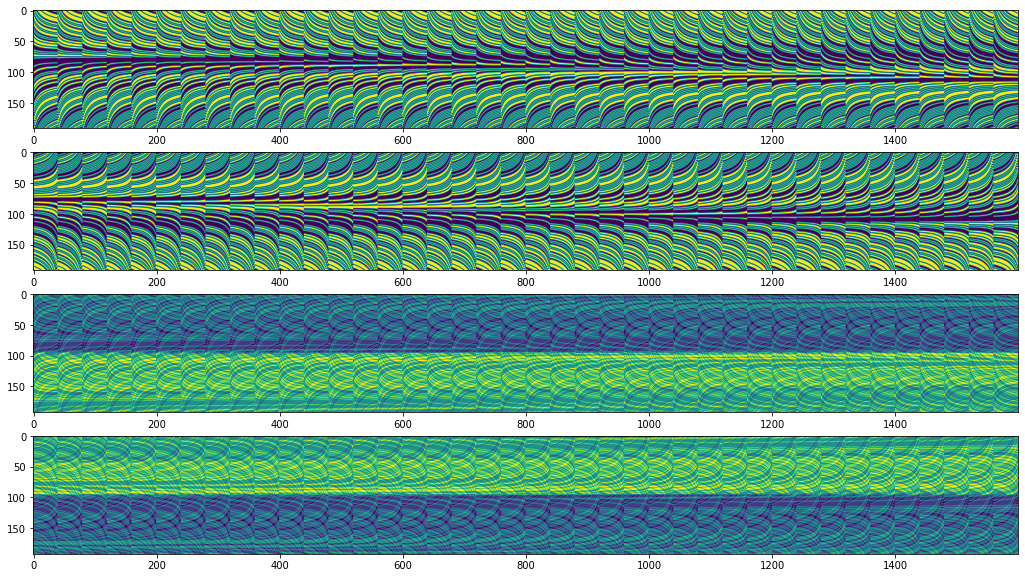

In [ ]:
# Small scale rotated forward model implementation

H_opp = np.rot90(np.rot90(H)) #opposite direction of H

theta = np.radians(45)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c, -s), (s, c)))
H45_new = np.reshape(H,(2,153600))
H45 = np.reshape(np.dot(R,H45_new),(192,1600)) # 45 degree forward model
H45_opp = np.rot90(np.rot90(H45)) # 45 deg forward model from opposite direction

plt.subplot(4,1,1)
plt.imshow(H)
plt.subplot(4,1,2)
plt.imshow(H_opp)
plt.subplot(4,1,3)
plt.imshow(H45)
plt.subplot(4,1,4)
plt.imshow(H45_opp)


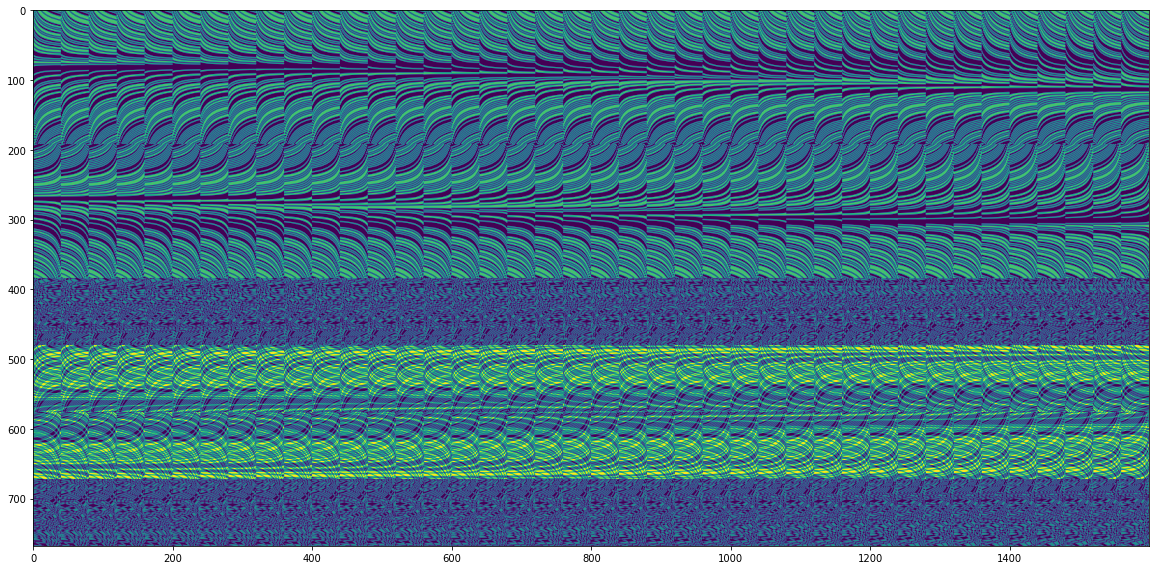

In [ ]:
# Combining all forward models
Htot1= np.concatenate((H, H_opp), axis = 0)
Htot2 = np.concatenate((H, H_opp, H90, H90_opp), axis = 0)
plt.imshow(Htot2)

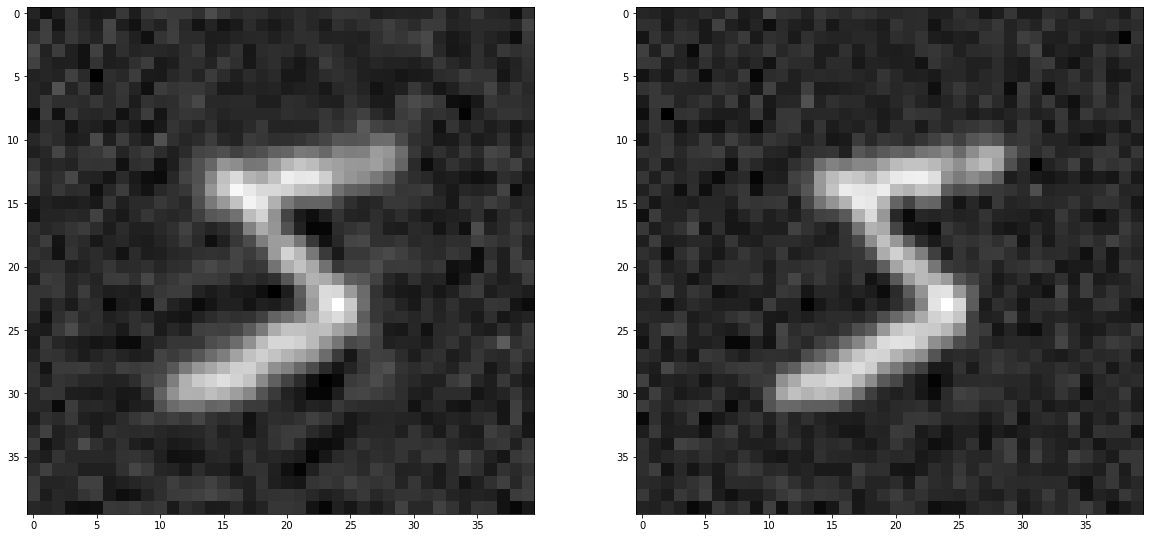

In [ ]:
Hfinal1 = np.reshape(np.matmul(np.linalg.pinv(Htot1),np.matmul(Htot1,np.reshape(x_train[0,:,:],N**2))),(N,N))
Hfinal2 = np.reshape(np.matmul(np.linalg.pinv(Htot2),np.matmul(Htot2,np.reshape(x_train[0,:,:],N**2))),(N,N))

plt.subplot(1,2,1)
plt.imshow(Hfinal1, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(Hfinal2, cmap='gray')

# Coded Aperture Projection (low complexity object)

After exploring the small scale implementations, we can now apply the methodology full-scale to the dataset of images. Investigating the two approaches above (applying single forward model to rotated images and applying rotated forward models to single images) has shown that the latter may produce the best results. As such, the method of applying rotated forward models will be used to perform coded aperture projection tomography from this point forth in the project. 

(8, 2, 2)
(16, 192, 1600)
(3072, 1600)


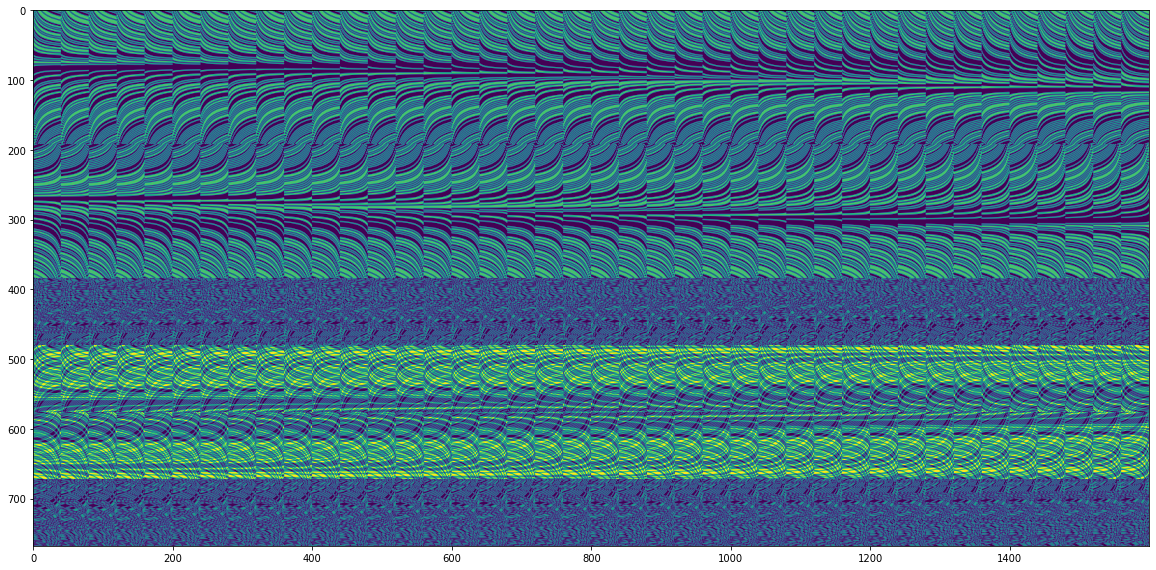

In [ ]:
# Rotated forward models
proj_num = 10         #number of proj angles (try 8, 10, 12, 18, 20, 24, 30, 36)
deg = np.linspace(0,360,proj_num)
rad = np.radians(deg)
R_all = []
H_all = []

for i in range(0,proj_num):
  c, s = np.cos(rad[i]), np.sin(rad[i])
  R = np.array(((c, -s), (s, c))) 
  R_all.append(R)

H_reshape = np.reshape(H,(2,153600))

for i in range(0,proj_num):
  H_theta = np.reshape(np.dot(R_all[i],H_reshape),(192,1600))
  H_theta_opp = np.rot90(np.rot90(H_theta))
  H_all.append(H_theta)
  H_all.append(H_theta_opp)

H_tot = np.zeros(np.shape(H_all))
H_tot = np.abs(np.vstack(H_all))

plt.imshow(H_tot[0:768,:])

print(np.shape(R_all))
print(np.shape(H_all))
print(np.shape(H_tot))

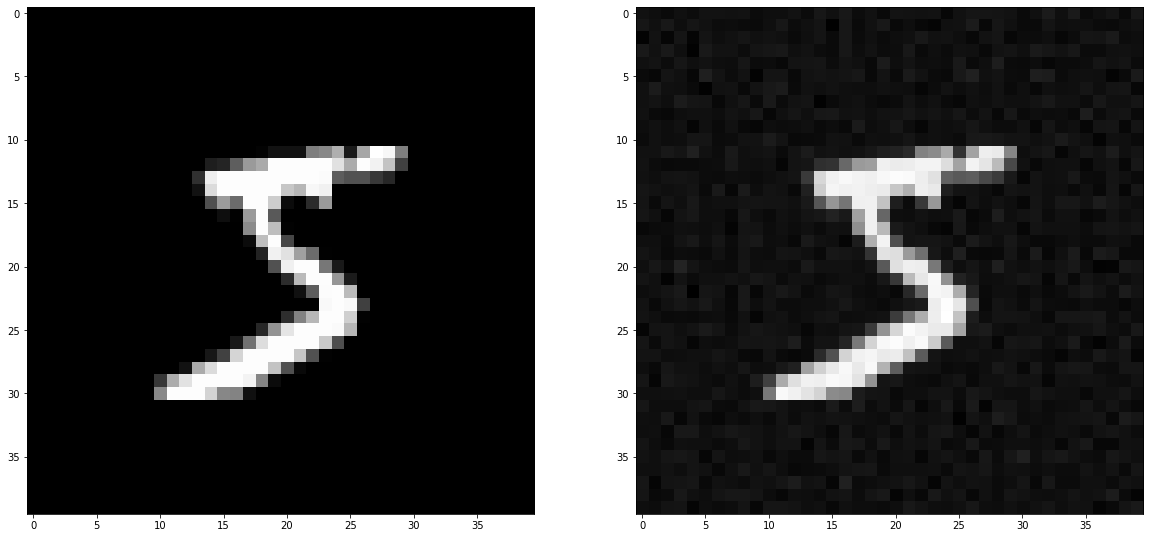

In [ ]:
# Applying to test image
obj = np.reshape(np.matmul(np.linalg.pinv(H_tot),np.matmul(H_tot,np.reshape(x_train[0,:,:],N**2))),(N,N))

plt.subplot(1,2,1)
plt.imshow(x_train[0], cmap = 'gray')
plt.subplot(1,2,2)
plt.imshow(obj, cmap = 'gray')

We have found from this test that for a simple object as above, only 10 projections are necessary to fully recover the original object. For 8 projections, we obtain only a slight amount of noise in the background, but the object is still very distinguishable, and almost an exact reconstruction of the original. I had intended to perform neural denoising on these projections to remove any residual artifacts, but it seems it is not necessary. Thus, we will now test the process on a more natural set of images and examine the performance. 

# Coded Aperture Projection Tomography (high complexity images, medical application)

I will be using diffusion weighted magnetic resonance images of rat brains which I have obtained from a current research project exploring effects of hypertension on micro-structures in the brain. While there may not be a need for coded aperture imaging in the field of magnetic resonance as compared to X-ray tomography or nuclear imaging (to reduce radiation exposure), these MR images are what I have on hand, and may act as a stand-in for a set of x-ray images as we are only really focused on object complexity at this point in time.  Let's see if we can clean up these images, and maybe attempt to create a 3D model from a number of brain image slices. 

## Load and Prep Data

(96, 96, 120, 216)


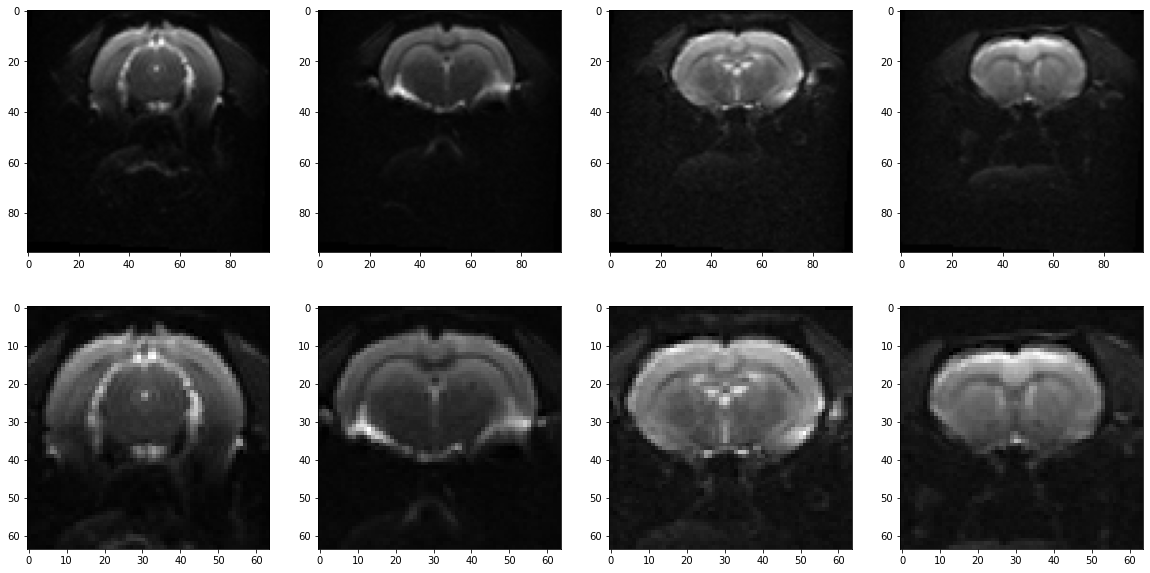

In [113]:
import nibabel as nib

# loading in NIFTI images and extracting axial volumes

brain = nib.load('rat10150_pre_dwi_DMC.nii')
brain = np.array(brain.dataobj)
brain = np.rot90(np.rot90(np.rot90(brain)))

plt.rcParams['figure.figsize'] = [20,10]
plt.subplot(2,4,1)
plt.imshow(brain[:,:,40,1], cmap = 'gray')
plt.subplot(2,4,2)
plt.imshow(brain[:,:,50,1], cmap = 'gray')
plt.subplot(2,4,3)
plt.imshow(brain[:,:,60,1], cmap = 'gray')
plt.subplot(2,4,4)
plt.imshow(brain[:,:,70,1], cmap = 'gray')

# Crop images so brain is roughly centered and is a smaller data size for processing
# We are only really interested in the brain mass, so we can crop the bottom portion

brain2 = np.zeros((64,64,120))
brain2[:,:,:] = brain[0:64,20:84,:,1]

plt.subplot(2,4,5)
plt.imshow(brain2[:,:,40], cmap = 'gray')
plt.subplot(2,4,6)
plt.imshow(brain2[:,:,50], cmap = 'gray')
plt.subplot(2,4,7)
plt.imshow(brain2[:,:,60], cmap = 'gray')
plt.subplot(2,4,8)
plt.imshow(brain2[:,:,70], cmap = 'gray')

## Create Aperture and Initial Forward Model

In [114]:
# Creating the forward model, H
# NOTE: l is object distance from the coded aperture in waves, delta is the 
#       spacing between object elements, d is the distance from the detector,
#       N is the size of our square test image, M is the length of the coded
#       aperture & height of the forward model matrix

l= 10
delta=1
N=64
M=220
pbar1 = ProgressBar()

code=np.random.randint(0,2,M)
def t(x):
  t=code[np.int(np.floor((x+M/2)/delta))]
  return t
vt=np.vectorize(t)
def p(j):
  xj, yj=delta*divmod(j,N)
  xj=xj-N*delta/2
  yj=yj+l
  return xj, yj
def g(j,x):
  g=t((x+(l/p(j)[1])*p(j)[0])/(1+(l/p(j)[1])))
  return g
def h(i,j):
  h=integrate.quad(lambda x: g(j,x), (i-M/2)*delta-delta/2,(i-M/2)*delta +delta/2)[0]
  return h
H=np.zeros((M,N**2))

for j in pbar1(range(N**2)):
  for i in range(M):
    H[i,j]=h(i,j)

100% (4096 of 4096) |####################| Elapsed Time: 0:15:35 Time:  0:15:35


In [117]:
#np.save('forwardH.npy', H)
np.save('brainImgs.npy', brain2)